This block keeps track of experiment parameters.

In [1]:
n_de_genes = 50
n_top_genes = 200

### Data Preprocessing

In [2]:
import anndata
import urllib.request

url = "https://drive.google.com/uc?export=download&id=1aZpy_l9xDQm5s0g17ztuizAFNbp5PX4L"
path, _ = urllib.request.urlretrieve(url)
adata = anndata.read_h5ad(path)

First we preprocess the data following `DE.Rmd` and filter to just the B or T cells.

In [3]:
import scanpy as sc

# Preprocess data
log_counts = sc.pp.log1p(adata, copy=True)
sc.pp.highly_variable_genes(log_counts, n_top_genes=n_top_genes)
adata = adata[:, log_counts.var['highly_variable']]

# Extract B cells and regulatory T cells
selected_cells = adata.obs['phenoid'].isin(['b.cells', 'regulatory.t'])
adata = adata[selected_cells]
adata.obs['cell_type'] = adata.obs['phenoid'].astype('category')

### Simulator Definition

Next we can define the original and synthetic control simulator.

In [4]:
from scdesigner.simulators import NegBinCopulaSimulator

sim = NegBinCopulaSimulator(epochs=10)
sim.fit(adata, {"mean": "~ cell_type"})

In [5]:
import scdesigner.transform as tr
from copy import deepcopy

means = sim.params["coef_mean"]
de_genes = set(means.loc["cell_type[T.regulatory.t]", :].abs().nlargest(n_de_genes).index)
non_de_genes = list(adata.var_names.difference(de_genes))


mask = tr.data_frame_mask(sim.params["coef_mean"], "cell_type", non_de_genes)
sim_null = deepcopy(sim)
sim_null.params = tr.nullify(sim_null.params, "coef_mean", mask)

### Power Analysis

Now we can run the power analysis using the same method described in `DE.Rmd`. The important part here is that we can sample from the control simulator. For now, we'll just test this with a single method.

In [6]:
test_methods = ["wilcoxon", "t-test", "t-test_overestim_var"]
q_values = {}
sim_data = sim_null.sample(adata.obs)
sim_data.X = 1e4 * sim_data.X / sim_data.X.sum(axis=1)[:, None]
sim_data = sc.pp.log1p(sim_data, copy=True)

for m in test_methods:
    sc.tl.rank_genes_groups(sim_data, "cell_type", method=m)
    q_values[m] = sc.get.rank_genes_groups_df(sim_data, "regulatory.t")

This populates the FDR and power across a range of q-value thresholds.

In [7]:
import numpy as np
import pandas as pd

target_fdr = np.concatenate([np.arange(0.01, 0.11, 0.01), np.arange(0.2, 0.6, 0.1)])
fdp_mat = pd.DataFrame(index=target_fdr, columns=test_methods)
power_mat = pd.DataFrame(index=target_fdr, columns=test_methods)

for test in test_methods:
    curr_p = q_values[test]
    for fdr in target_fdr:
        discoveries = curr_p[curr_p.pvals_adj <= fdr].names
        tp = len(de_genes.intersection(discoveries))
        fdp_mat.loc[fdr, test] = (len(discoveries) - tp) / len(discoveries) if len(discoveries) > 0 else 0
        power_mat.loc[fdr, test] = tp / len(de_genes)

In [8]:
power_mat
fdp_mat

,wilcoxon,t-test,t-test_overestim_var
0.01,0.028571,0.020408,0.020408
0.02,0.028571,0.02,0.02
0.03,0.027778,0.057692,0.057692
0.04,0.027778,0.056604,0.056604
0.05,0.078947,0.074074,0.074074
0.06,0.102564,0.074074,0.074074
0.07,0.102564,0.074074,0.074074
0.08,0.1,0.074074,0.074074
0.09,0.1,0.090909,0.090909
0.10,0.1,0.090909,0.090909


### Visual Checks

These false discovery rates are a bit higher than those in the current scDesigner vignette (~ 60% vs. 30%). We double check the simulator using some visualizations. They seem generally reasonable. The best explanation I have for the discrepancy is that `scanpy`'s selection of highly variable genes is not exactly the same as those in `Seurat`, which uses a variance stabilizing transform.

In [9]:
import altair as alt
alt.renderers.enable('png')

def boxplots(adata, genes=None):
    if genes is None:
        genes = adata.var_names[:10]

    plot_data = pd.DataFrame(adata.X, columns=adata.var_names)
    plot_data["cell_type"] = adata.obs["cell_type"].values
    return alt.Chart(plot_data).transform_fold(
        genes,
        as_=['Gene', 'Expression']
    ).mark_boxplot().encode(
        x='cell_type:N',
        y='Expression:Q',
        color='cell_type:N',
        column='Gene:N'
    ).properties(width=50, height=300)

These are some of the real data.

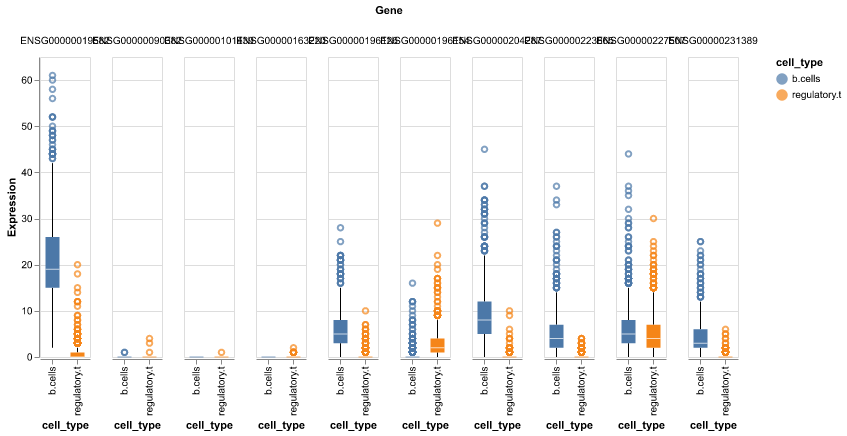

In [10]:
boxplots(adata)

Here is the unaltered simulator, for the exact same genes.

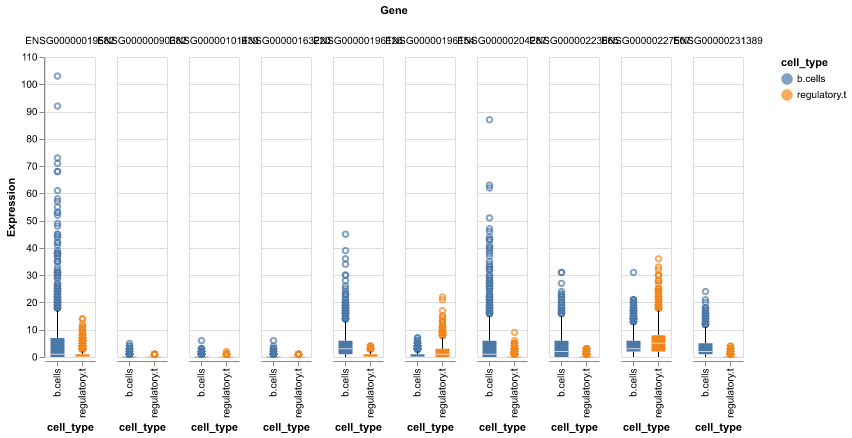

In [11]:
boxplots(sim.sample(adata.obs))

Here are simulated, true DE genes.

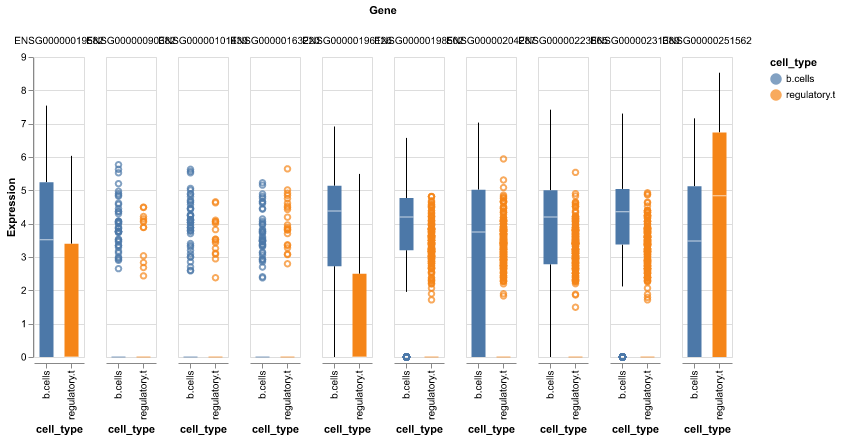

In [12]:
boxplots(sim_data[:, [v in de_genes for v in sim_data.var_names]]).show()

Here are simulated non-DE genes.

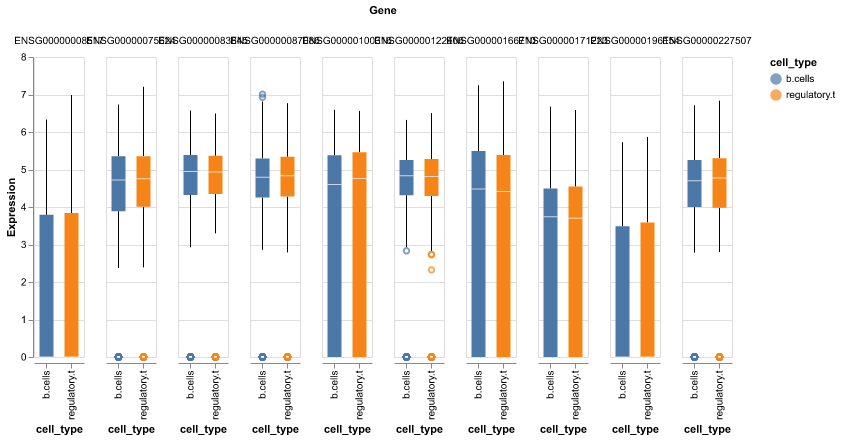

In [13]:
boxplots(sim_data[:, [v not in de_genes for v in sim_data.var_names]]).show()